# Summary

**Bottom line**: Out-of-sample accuracy with logistic regression and random forest classification is currently stuck at 87-88%. Incorporating the outputs of an off-the-shelf BERT from Hugging Face for sentiment analysis did not improve performance. I recommend gathering more class-balanced data and exploring LLMs. 

In this notebook I sought to benchmark the high school student's methods on the new dataset (Saloni's emails, as opposed to Siya's) and improve them using regularization, hyperparameter optimization, and by incorporating the outputs of a BERT (large language model) trained to do spam detection as features. The results suggest that classical models not heavily supported by LLMs will likely not yield an optimal solution. Perhaps we should discard them altogether.

Moving forward, there are variious applications of LLMs that I believe could help:
1. **Using the outputs of specific LLMs as features into a new model.** In this model, I hoped that the outputs of a single BERT designed to detect spam would allow a random forest to discard irrelevant emails more easily. It turned out not to help very much because the random forests were good at that by themselves (had few false positives), but it demonstrates how easy it is to pull a model and use it. I envision using nultiple BERTs to provide metrics like "is spam," "is urgent," "is related to work," etc. and using them as features in combination with representations of raw text. Transfer learning could be involved.
2. **Using API calls to chat GPT-4.** Another way to do the above is simply to make calls to the API explaining in enlish how you want the model to evaluate and tag an email. This will provide the same functionality as the BERTs idea with the added pro that it will be simpler and the con that it will be less predictable/tunable. 
3. **Discarding classical models altogether and just using an LLM as the primary predictor.**
4. (lower value) Doing separate embeddings of email body, past threads, sender, etc and seeing how it affects classical models, as we talked about in a previous meeting. Doing this data processing is a nontrivial task becuse the content of email bodies in the data is inconsistent.

Additionally, a substantial issue that seems to hinder the models in this notebook is class imbalance. There are comparatively few emails that received a response. Upsampling the positive examples reduced the false negative rate of a random forest classifier substantially. We should bear in mind the issue of class IMbalance. 





In [620]:
import pandas as pd
import numpy as np
import openai
import tiktoken
import os

openai.api_key = os.getenv("OPENAI_API_KEY")

## Import Data

In [2]:
df = pd.read_parquet(path='/Users/evanvietorisz/Desktop/Saloni/saloni_data.parquet')

## Preprocessing

In [3]:
df.head()

,subject,sender,date,snippet,body,replied_to
0,"Earnings by the dozen, Triller's IPO dreams, a...",StrictlyVC <connie@strictlyvc.com>,2023-08-04 06:25:51,"View in browser Top News Hello! Apple, Amazon,...","Hello,\r\n\r\nYou have received a newsletter f...",0
1,[YC Co-Founder Matching] New message from KART...,Y Combinator <no-reply@ycombinator.com>,2023-08-04 06:20:20,Y Combinator Logo -- REPLY ABOVE THIS LINE -- ...,Y Combinator Logo \r\n( https://email.email.yc...,0
2,"New Event: KARTIK ARORA - 10:00pm Fri, Aug 4, ...",Calendly <notifications@calendly.com>,2023-08-04 06:14:28,"Hi Saloni Goel, A new event has been scheduled...","<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",0
3,Meeting: Meeting for Gmail API is ready for re...,Sybill Notifications <do-not-reply@sybill.ai>,2023-08-04 05:25:29,Meeting for Gmail API 3 AUGUST 2023 - 08:56 PM...,Meeting for Gmail API\r\n\r\n3 AUGUST 2023 - 0...,0
4,File token.json is available in the workspace ...,<saloni07@stanford.edu>,2023-08-04 04:34:21,"Greetings, A file has just been uploaded in th...","<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0


In [4]:
df.shape

(42186, 6)

In [5]:
#remove entries where body of email is empty
df = df[df['body']!='']

In [6]:
df.shape

(26024, 6)

In [21]:
#make dates human readable
df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).strftime('%b %d, %Y'))

In [31]:
#replace carriage returns with spaces
df['body'] = df['body'].apply(lambda x: x.replace('\r\n', ' '))

## Generate embeddings from OpenAI


In [10]:
encoding_method = "cl100k_base"
openai_model = "text-embedding-ada-002"
    
def encoding_length(text, encoding_method):
    encoding = tiktoken.get_encoding(encoding_method)
    tokens = encoding.encode(text)
    return len(tokens)

def get_embedding(text, model):
    return openai.Embedding.create(input=[text], model=openai_model)['data'][0]['embedding']

In [ ]:
#concat all content into one feature
df['all_content'] = ("Subject: " + df['subject'] + " Sender: " + df['sender'] \
     + " Date: " + df['date'] + " Body: " + df['body'])

#remove entries that are too long
df['encoding_length'] = df['all_content'].apply(lambda x: encoding_length(x, encoding_method))

df = df[df['encoding_length'] < 8100]

#generate embeddings
df['embedding'] = df['all_content'].apply(lambda x: get_embedding(x, model=openai_model))

#SAVE
filename = 'binary_output_dataset_all_content_concatendated_then_embedded_Aug11.csv'
pathname = '/Users/evanvietorisz/Desktop/Saloni/'

df.to_csv(pathname+filename)

## Drop duplicates

In [589]:
print(df[['sender','subject','date','body','replied_to']].duplicated().sum())

df = df.drop_duplicates(subset=['sender','subject','date','body', 'replied_to'])

df.shape

17036


(7170, 9)

## Logistic Regression

In [590]:
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import math

plt.style.use('fivethirtyeight')

random.seed(10)
random_state = 10

def magnitude(x: np.ndarray) -> float:
    return math.sqrt(pow(x,2).sum())

def normalize(X: np.ndarray) -> np.ndarray:
    X = X.copy()
    for i in range(X.shape[1]):
        X[:,i] = X[:,i] / magnitude(X[:,i])
    return X
      

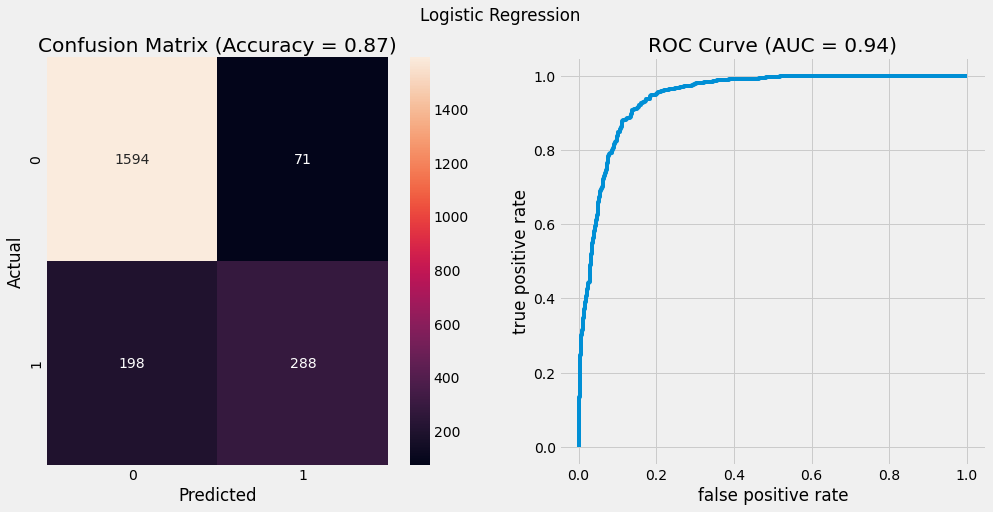

                precision    recall  f1-score   support

not replied to       0.89      0.96      0.92      1665
    replied to       0.80      0.59      0.68       486

      accuracy                           0.87      2151
     macro avg       0.85      0.77      0.80      2151
  weighted avg       0.87      0.87      0.87      2151



In [592]:
X = normalize(np.stack(np.array(df['embedding']))) #normalize it 
y = df['replied_to']

fig_title = "Logistic Regression"


###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

model = LogisticRegression(random_state=random_state)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_raw_outputs = model.predict_proba(X_test)[:,1]

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

fpr, tpr, _ = metrics.roc_curve(y_test, y_raw_outputs)
auc = metrics.auc(fpr, tpr) 

target_names=['not replied to', 'replied to']
report = metrics.classification_report(y_test, y_pred, target_names=target_names)
accuracy = report.split('accuracy')[1].lstrip()[:4]


fig, ax = plt.subplots(1,2, figsize=(15,7))
fig.suptitle(fig_title)

sns.heatmap(cnf_matrix, annot=True, fmt='d', ax=ax[0])
ax[0].set_title('Confusion Matrix (Accuracy = {})'.format(accuracy))
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr,tpr)
ax[1].set_title('ROC Curve (AUC = {:.2f})'.format(auc))
ax[1].set_xlabel('false positive rate')
ax[1].set_ylabel('true positive rate')

plt.show()

print(report)

## Random forest

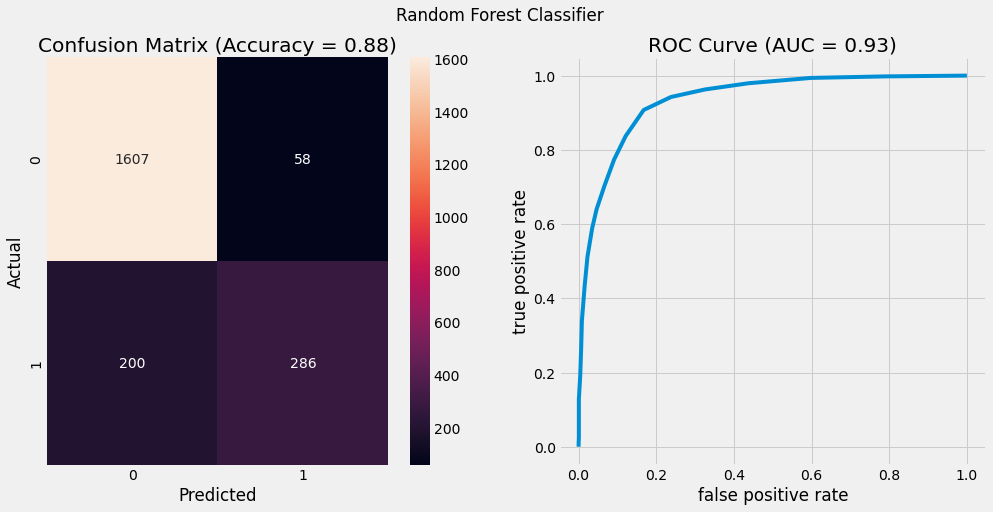

                precision    recall  f1-score   support

not replied to       0.89      0.97      0.93      1665
    replied to       0.83      0.59      0.69       486

      accuracy                           0.88      2151
     macro avg       0.86      0.78      0.81      2151
  weighted avg       0.88      0.88      0.87      2151



In [594]:
X = normalize(np.stack(np.array(df['embedding']))) #normalize it 
y = df['replied_to']

fig_title = "Random Forest Classifier"


###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

model = RandomForestClassifier(n_estimators = 20, random_state=random_state)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_raw_outputs = model.predict_proba(X_test)[:,1]

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

fpr, tpr, _ = metrics.roc_curve(y_test, y_raw_outputs)
auc = metrics.auc(fpr, tpr) 

target_names=['not replied to', 'replied to']
report = metrics.classification_report(y_test, y_pred, target_names=target_names)
accuracy = report.split('accuracy')[1].lstrip()[:4]


fig, ax = plt.subplots(1,2, figsize=(15,7))
fig.suptitle(fig_title)

sns.heatmap(cnf_matrix, annot=True, fmt='d', ax=ax[0])
ax[0].set_title('Confusion Matrix (Accuracy = {})'.format(accuracy))
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr,tpr)
ax[1].set_title('ROC Curve (AUC = {:.2f})'.format(auc))
ax[1].set_xlabel('false positive rate')
ax[1].set_ylabel('true positive rate')

plt.show()

print(report)

Compared to a random forest on a dataset with duplicates run by mistake (not shown), this performance is poor. Let's diagnose the problem:

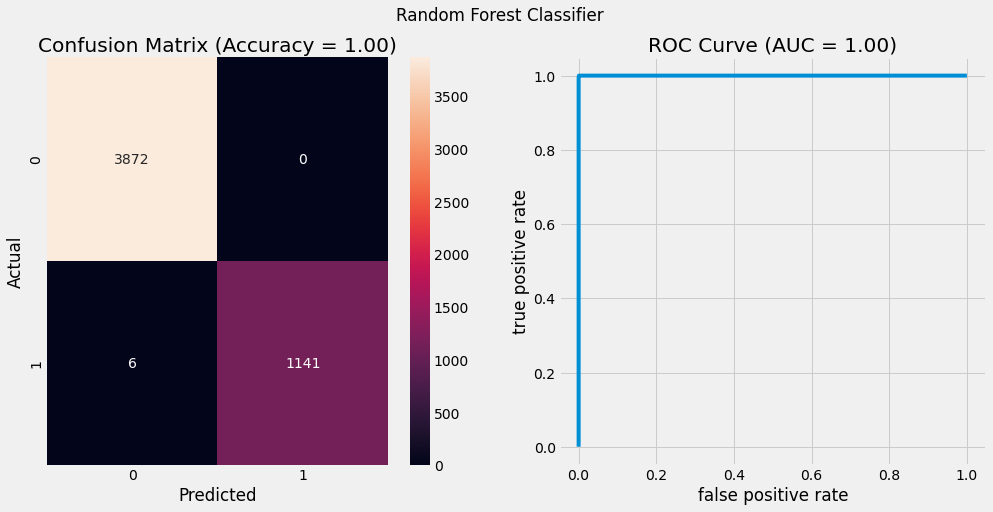

                precision    recall  f1-score   support

not replied to       1.00      1.00      1.00      3872
    replied to       1.00      0.99      1.00      1147

      accuracy                           1.00      5019
     macro avg       1.00      1.00      1.00      5019
  weighted avg       1.00      1.00      1.00      5019



In [596]:
#training performance

training_predictions = model.predict(X_train)
training_predictions_raw = model.predict_proba(X_train)[:,1]

cnf_matrix = metrics.confusion_matrix(y_train, training_predictions)

fpr, tpr, _ = metrics.roc_curve(y_train, training_predictions_raw)
auc = metrics.auc(fpr, tpr) 

target_names=['not replied to', 'replied to']
report = metrics.classification_report(y_train, training_predictions, target_names=target_names)
accuracy = report.split('accuracy')[1].lstrip()[:4]


fig, ax = plt.subplots(1,2, figsize=(15,7))
fig.suptitle(fig_title)

sns.heatmap(cnf_matrix, annot=True, fmt='d', ax=ax[0])
ax[0].set_title('Confusion Matrix (Accuracy = {})'.format(accuracy))
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr,tpr)
ax[1].set_title('ROC Curve (AUC = {:.2f})'.format(auc))
ax[1].set_xlabel('false positive rate')
ax[1].set_ylabel('true positive rate')

plt.show()

print(report)

The model is overfitting and not generalizing to training data

## Random forest with regularization - hyperparameter optimization

In [597]:
X = normalize(np.stack(np.array(df['embedding']))) #normalize it 
y = df['replied_to']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

max_depth_vals = [4,8,12,16,20,24,28,32] #log2 is 12, unconstrained went to 30
max_features_vals = [1,2,5,10,15,20,25,30,35,40,45,50] #sqrt is around 40, log is 10
min_samples_leaf_vals = [1,5,10,15,20]

results = {}

for max_depth in max_depth_vals:
    for max_features in num_features_vals:
        for min_samples_leaf in min_samples_leaf_vals:
            model = RandomForestClassifier(
                random_state=random_state,
                n_estimators=20,
                max_depth=max_depth,
                max_features=max_features,
                min_samples_leaf=min_samples_leaf,
            )
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = metrics.accuracy_score(y_test, y_pred)
            
            results[(max_depth,max_features,min_samples_leaf)] = {'accuracy': accuracy, 'model': model}
            

In [600]:
max_accuracy = -float('inf')
best_params = None

for key in results.keys():
    if results[key]['accuracy'] > max_accuracy:
        max_accuracy = results[key]['accuracy']
        best_params = key


In [602]:
model = results[best_params]['model']

accuracy = results[best_params]['accuracy']

print('accuracy: {}'.format(accuracy))

print('best params: {}'.format(best_params))


accuracy: 0.8637842863784286
best params: (12, 5, 1)


Sweep over plausuble regularization params worsens performance

## Random Forest upsampling pos examples, no regularization

In [493]:
from sklearn.utils import resample

no_reply = pure_df[pure_df['replied_to']==0]
reply = pure_df[pure_df['replied_to']==1]


reply_upsample = resample(reply,
             replace=True,
             n_samples=len(no_reply),
             random_state=random_state)

print(reply_upsample.shape)

(5537, 9)


In [494]:
no_reply.shape

(5537, 9)

In [495]:
pure_df_upsampled = pd.concat([no_reply, reply_upsample])

In [499]:
#so now let's retrain

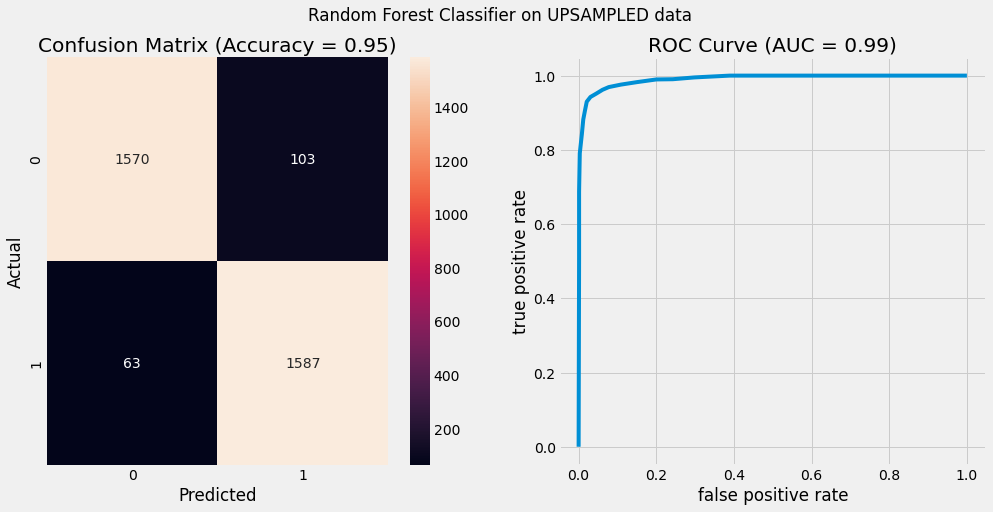

In [604]:
X = normalize(np.stack(np.array(pure_df_upsampled['embedding']))) #normalize it 
y = pure_df_upsampled['replied_to']

fig_title = "Random Forest Classifier on UPSAMPLED data"


###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

model = RandomForestClassifier(n_estimators = 20, random_state=random_state)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_raw_outputs = model.predict_proba(X_test)[:,1] #decision function

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

fpr, tpr, _ = metrics.roc_curve(y_test, y_raw_outputs)
auc = metrics.auc(fpr, tpr) 

target_names=['not replied to', 'replied to']
report = metrics.classification_report(y_test, y_pred, target_names=target_names)
accuracy = report.split('accuracy')[1].lstrip()[:4]


fig, ax = plt.subplots(1,2, figsize=(15,7))
fig.suptitle(fig_title)

sns.heatmap(cnf_matrix, annot=True, fmt='d', ax=ax[0])
ax[0].set_title('Confusion Matrix (Accuracy = {})'.format(accuracy))
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr,tpr)
ax[1].set_title('ROC Curve (AUC = {:.2f})'.format(auc))
ax[1].set_xlabel('false positive rate')
ax[1].set_ylabel('true positive rate')

plt.show()

### This inflates accuracy because examples from training can be passed in during validation, but it shows that increasing number of positive examples can help reduce gross number of false negatives (lower left quadrant)

## Do same with logistic regressor

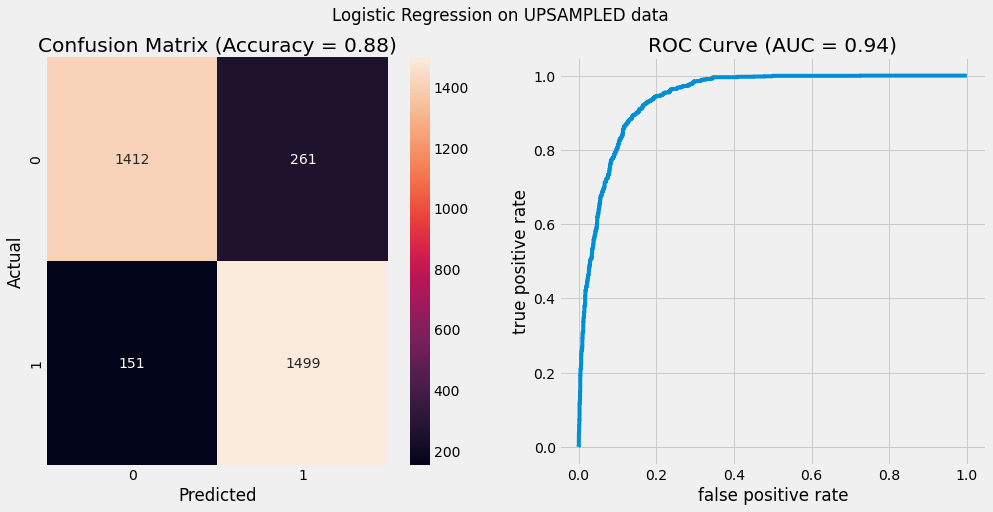

                precision    recall  f1-score   support

not replied to       0.90      0.84      0.87      1673
    replied to       0.85      0.91      0.88      1650

      accuracy                           0.88      3323
     macro avg       0.88      0.88      0.88      3323
  weighted avg       0.88      0.88      0.88      3323



In [603]:
X = normalize(np.stack(np.array(pure_df_upsampled['embedding']))) #normalize it 
y = pure_df_upsampled['replied_to']

fig_title = "Logistic Regression on UPSAMPLED data"


###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

model = LogisticRegression(random_state=random_state)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_raw_outputs = model.predict_proba(X_test)[:,1]

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

fpr, tpr, _ = metrics.roc_curve(y_test, y_raw_outputs)
auc = metrics.auc(fpr, tpr) 

target_names=['not replied to', 'replied to']
report = metrics.classification_report(y_test, y_pred, target_names=target_names)
accuracy = report.split('accuracy')[1].lstrip()[:4]


fig, ax = plt.subplots(1,2, figsize=(15,7))
fig.suptitle(fig_title)

sns.heatmap(cnf_matrix, annot=True, fmt='d', ax=ax[0])
ax[0].set_title('Confusion Matrix (Accuracy = {})'.format(accuracy))
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr,tpr)
ax[1].set_title('ROC Curve (AUC = {:.2f})'.format(auc))
ax[1].set_xlabel('false positive rate')
ax[1].set_ylabel('true positive rate')

plt.show()

print(report)

## Repeat with undersampled data

In [606]:
no_reply = df[df['replied_to']==0]
reply = df[df['replied_to']==1]


no_reply_downsample = resample(no_reply,
             replace=True,
             n_samples=len(reply),
             random_state=random_state)

In [607]:
df_downsampled = pd.concat([no_reply_downsample, reply])

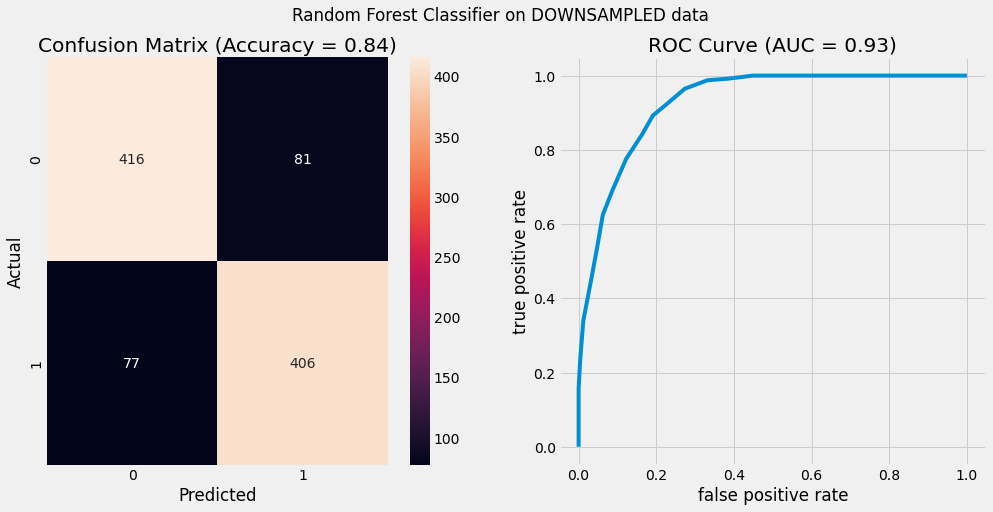

In [608]:
X = normalize(np.stack(np.array(df_downsampled['embedding']))) #normalize it 
y = df_downsampled['replied_to']

fig_title = "Random Forest Classifier on DOWNSAMPLED data"


###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

model = RandomForestClassifier(n_estimators = 20, random_state=random_state)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_raw_outputs = model.predict_proba(X_test)[:,1] #decision function

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

fpr, tpr, _ = metrics.roc_curve(y_test, y_raw_outputs)
auc = metrics.auc(fpr, tpr) 

target_names=['not replied to', 'replied to']
report = metrics.classification_report(y_test, y_pred, target_names=target_names)
accuracy = report.split('accuracy')[1].lstrip()[:4]


fig, ax = plt.subplots(1,2, figsize=(15,7))
fig.suptitle(fig_title)

sns.heatmap(cnf_matrix, annot=True, fmt='d', ax=ax[0])
ax[0].set_title('Confusion Matrix (Accuracy = {})'.format(accuracy))
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr,tpr)
ax[1].set_title('ROC Curve (AUC = {:.2f})'.format(auc))
ax[1].set_xlabel('false positive rate')
ax[1].set_ylabel('true positive rate')

plt.show()

## Add a feature using a pretrained spam detection BERT model 

In [514]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [515]:
huggingface_model = "mrm8488/bert-tiny-finetuned-enron-spam-detection"

tokenizer = AutoTokenizer.from_pretrained(huggingface_model)
spam_classifier = AutoModelForSequenceClassification.from_pretrained(huggingface_model)

In [609]:
def get_BERT_output(s): #gives prob NOT SPAM
    text = s[0:550] #empirically determined
    encoding = tokenizer(text=text, return_tensors='pt')
    output = spam_classifier(**encoding)
    return softmax(output[0][0].detach().numpy())

In [610]:
df['BERT_output'] = df['body'].apply(get_BERT_output)

<ipython-input-610-cd680a9ad4c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BERT_output'] = df['body'].apply(get_BERT_output)


## BERT output as prediction itself

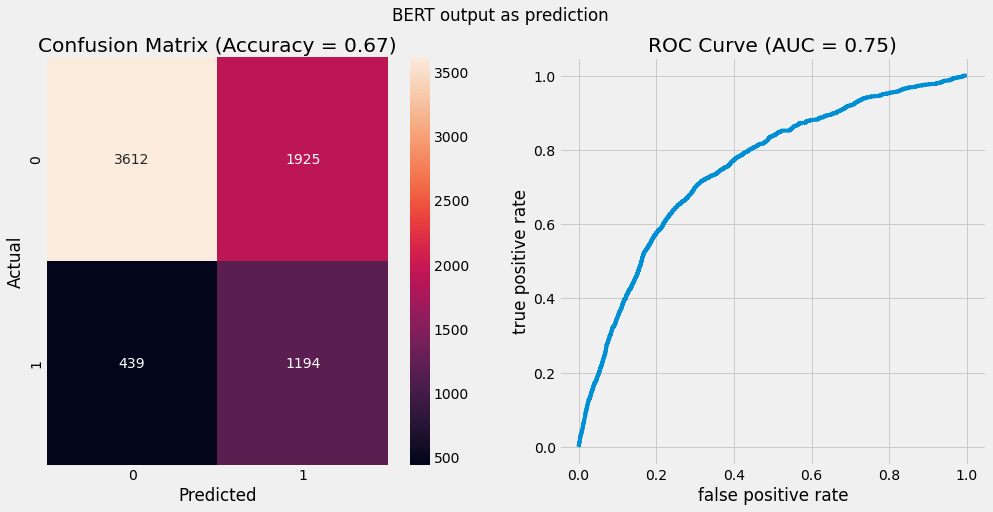

                precision    recall  f1-score   support

not replied to       0.89      0.65      0.75      5537
    replied to       0.38      0.73      0.50      1633

      accuracy                           0.67      7170
     macro avg       0.64      0.69      0.63      7170
  weighted avg       0.78      0.67      0.70      7170



In [618]:

fig_title = 'BERT output as prediction'

y_test = df['replied_to']

y_pred = (df['BERT_output'].apply(lambda x: 1 if x[0] > 0.5 else 0))
y_raw_outputs = df['BERT_output'].apply(lambda x: x[0])

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

fpr, tpr, _ = metrics.roc_curve(y_test, y_raw_outputs)
auc = metrics.auc(fpr, tpr) 

target_names=['not replied to', 'replied to']
report = metrics.classification_report(y_test, y_pred, target_names=target_names)
accuracy = report.split('accuracy')[1].lstrip()[:4]


fig, ax = plt.subplots(1,2, figsize=(15,7))
fig.suptitle(fig_title)

sns.heatmap(cnf_matrix, annot=True, fmt='d', ax=ax[0])
ax[0].set_title('Confusion Matrix (Accuracy = {})'.format(accuracy))
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr,tpr)
ax[1].set_title('ROC Curve (AUC = {:.2f})'.format(auc))
ax[1].set_xlabel('false positive rate')
ax[1].set_ylabel('true positive rate')

plt.show()

print(report)

This by itself does poorly

## Random forest including BERT data

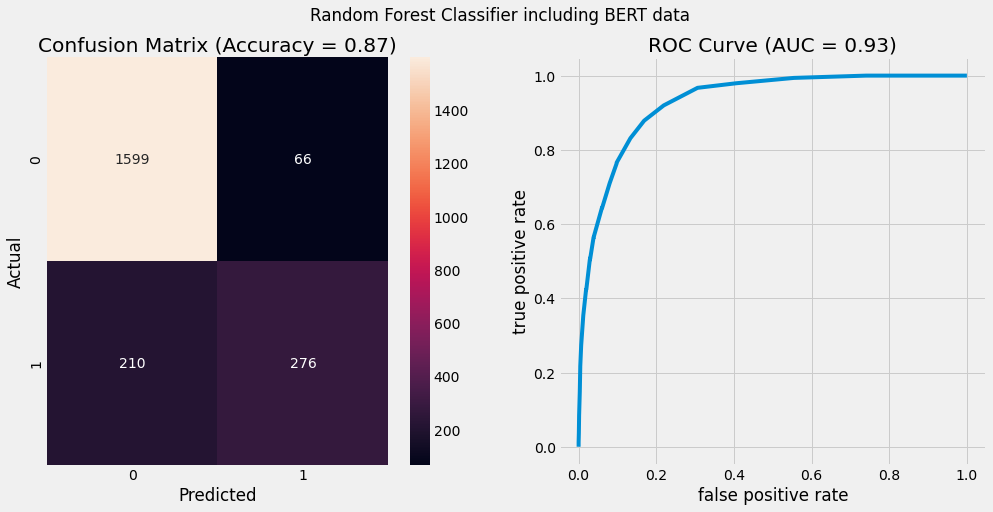

                precision    recall  f1-score   support

not replied to       0.88      0.96      0.92      1665
    replied to       0.81      0.57      0.67       486

      accuracy                           0.87      2151
     macro avg       0.85      0.76      0.79      2151
  weighted avg       0.87      0.87      0.86      2151



In [619]:
X = np.concatenate(
    (
        normalize(np.stack(np.array(df['BERT_output']))),
        normalize(np.stack(np.array(df['embedding'])))
    ),
    axis=1)

y = df['replied_to']

fig_title = "Random Forest Classifier including BERT data"


###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

model = RandomForestClassifier(n_estimators = 20, random_state=random_state)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_raw_outputs = model.predict_proba(X_test)[:,1] #decision function

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

fpr, tpr, _ = metrics.roc_curve(y_test, y_raw_outputs)
auc = metrics.auc(fpr, tpr) 

target_names=['not replied to', 'replied to']
report = metrics.classification_report(y_test, y_pred, target_names=target_names)
accuracy = report.split('accuracy')[1].lstrip()[:4]


fig, ax = plt.subplots(1,2, figsize=(15,7))
fig.suptitle(fig_title)

sns.heatmap(cnf_matrix, annot=True, fmt='d', ax=ax[0])
ax[0].set_title('Confusion Matrix (Accuracy = {})'.format(accuracy))
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr,tpr)
ax[1].set_title('ROC Curve (AUC = {:.2f})'.format(auc))
ax[1].set_xlabel('false positive rate')
ax[1].set_ylabel('true positive rate')

plt.show()
print(report)

## Aux code for viewing false positives/negatives

In [ ]:
false_negatives = y_test[(y_test != y_pred) & (y_test==1)].index.tolist()

false_positives = y_test[(y_test != y_pred) & (y_test==0)].index.tolist()

for i in false_negatives:
    print(df.loc[i]['body'])
    print("_________________________________________________________________________________________________________")

for i in false_positives:
    print(df.loc[i]['body'])
    print("_________________________________________________________________________________________________________")